# Choosing 401(k)'s with Bayesian Inference

I'm apparently an adult now that I got a job, moved to Brooklyn with the boyfriend, with a dog and a station wagon, etc. One of the many "fun" things about adulting is that I even though I'm in my late-20s, I get to start worrying about ~~dying~~ retiring!? 

Seeing as I've procrastinated long enough on actually doing something with my retirement money, I finally decided to do something. 

To me, the most important thing when putting money away for retirement is how safe that money will be, followed by the magnitude of the returns (i.e., I would  rather have my money in a place that was resilient in downturns in the market, with returns that are competitive or do slightly better than interest). After all, it would suck to lose it all and be broke when old!

[stochastic volatility](http://www.investopedia.com/terms/s/stochastic-volatility.asp "stochastic volatility"). The pymc3 package appeared to be a good contender for efficiently making Bayesian inferences. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

I can pull market data from Yahoo easily using pandas-datareader. There are many possible indicies I can use, but for now, I'll just look at the returns from the S&P 500. Since I want to minimize risk with my retirement funds, I'm interested in volatilities around the Great Recession of 2008. 

In [2]:
try:
    from pandas_datareader import data
except ImportError:
    #!pip install pandas-datareader
    import pip
    pip.main(['install', 'pandas-datareader']) 
    from pandas_datareader import data
returns = data.get_data_yahoo('SPY', start='2008-5-1', end='2009-12-1')['Adj Close'].pct_change()

Now, let's define the model. I'm not a finance expert, so I'll use a model previously proposed [here](https://peerj.com/articles/cs-55.pdf), which is summarized below:
$$ 
\begin{align}
\sigma &\sim \exp(50) \\
\nu &\sim \exp(0.1) \\
s_i &\sim \mathrm{Normal} (s_{i-1}, \sigma^2) \\
\log(y_i) &\sim \mathrm{StudentT}(\nu, 0, \exp(-2s_i)) 
\end{align}
$$

Here is an explanation for the model. The response $ y $, or the returns, is modeled as a Student's-T distribution with unknown degrees of freedom.

In [3]:
from pymc3 import Model
from pymc3 import Exponential, StudentT, Deterministic
from pymc3.distributions.timeseries import GaussianRandomWalk
from pymc3.math import exp
with Model() as sp500_model:
    nu = Exponential('nu', 1./10, testval=5.)
    sigma = Exponential('sigma', 1./.02, testval=.1)
    s = GaussianRandomWalk('s', sigma**-2, shape=len(returns))
    volatility_process = Deterministic('volatility_process', exp(-2*s))
    r = StudentT('r', nu, lam=1/volatility_process, observed=returns)

From here, we can do the actual sampling to (?)!

In [4]:
from pymc3 import variational
from pymc3 import NUTS, sample
from scipy import optimize
with sp500_model:
    mkt_trace = sample(2000, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 883.27: 100%|█████████| 200000/200000 [00:43<00:00, 4570.07it/s]
Finished [100%]: Average ELBO = 883.21


Quickly, let's plot the Bayesian-modeled volatilities with the market returns to see if they make sense:

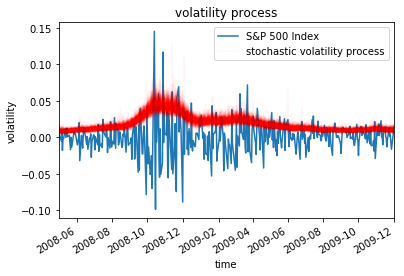

In [5]:
fig, ax = plt.subplots()
returns.plot(ax=ax)
ax.plot(returns.index, 1/np.exp(mkt_trace['s',::5].T), 'r', alpha=.03);
ax.set(title='volatility process', xlabel='time', ylabel='volatility');
ax.legend(['S&P 500 Index', 'stochastic volatility process'])
plt.show()

Intuitively, volatility of the S&P 500 (shown in red) increased dramatically when the market crashed, and this increase in volatility matches the increase in the variance of returns as well. Over time as the economy recovered from the recession, the volatility decreases as well. From what I see here, this makes sense.

Time to start analyzing retirement fund volatilities! Just for quick illustration here, I will pull example retirement funds from the Thrift Savings Plan (TSP) database, again using pandas-datareader. And then, I will use the percent change of these funds over the same time period to compare their volatilities with the market. First, gotta load the TSP data, and clean it up a little.

In [8]:
import pandas_datareader.tsp as tsp
tspreader = tsp.TSPReader(start='2008-5-1', end='2009-12-1').read()
tspreader = tspreader.dropna()
tspreader = tspreader.drop('L 2050', axis=1)
tspreader = tspreader.drop('', axis=1)

Now, I just have to re-run the model for each fund and compare results with the market volatility indices! Let's see how much variation of volatility is present between different retirement fund offerings...

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 1,381.3: 100%|████████| 200000/200000 [00:44<00:00, 4460.10it/s]
Finished [100%]: Average ELBO = 1,381.2


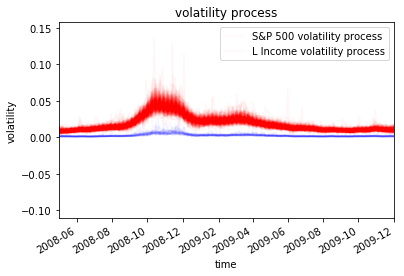

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 948.62: 100%|█████████| 200000/200000 [00:45<00:00, 4363.00it/s]
Finished [100%]: Average ELBO = 948.92


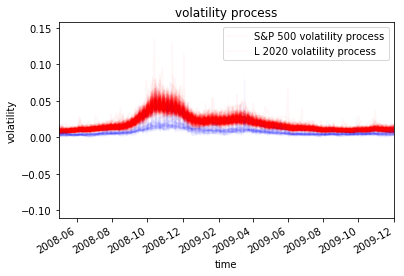

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 875.87: 100%|█████████| 200000/200000 [00:45<00:00, 4427.33it/s]
Finished [100%]: Average ELBO = 876.17


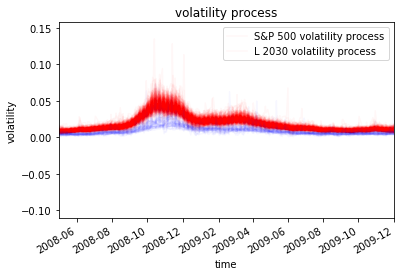

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 823.98: 100%|█████████| 200000/200000 [00:46<00:00, 4340.37it/s]
Finished [100%]: Average ELBO = 824.16


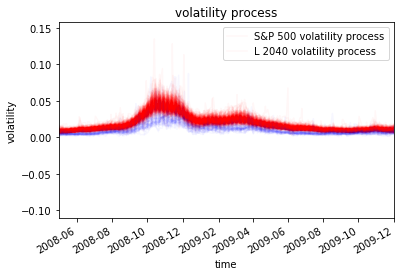

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 2,707.9: 100%|████████| 200000/200000 [00:45<00:00, 4382.31it/s]
Finished [100%]: Average ELBO = 2,734.1


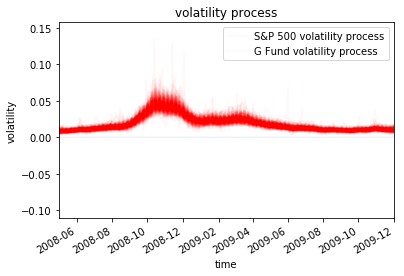

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 1,437.1: 100%|████████| 200000/200000 [00:46<00:00, 4340.18it/s]
Finished [100%]: Average ELBO = 1,437.1


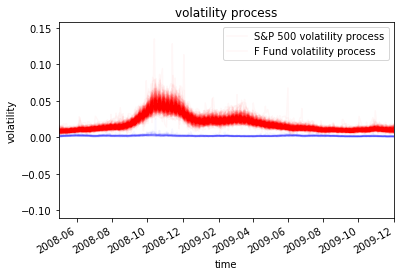

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 745.24: 100%|█████████| 200000/200000 [00:46<00:00, 4262.67it/s]
Finished [100%]: Average ELBO = 744.98


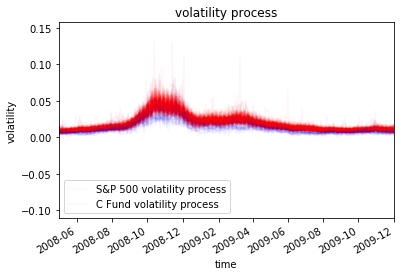

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 682.66: 100%|█████████| 200000/200000 [00:46<00:00, 4319.09it/s]
Finished [100%]: Average ELBO = 682.52


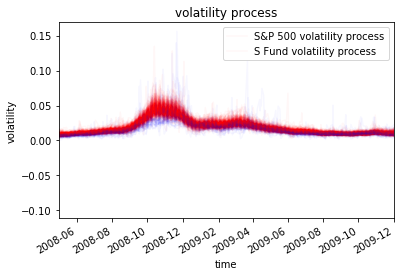

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 727.82: 100%|█████████| 200000/200000 [00:46<00:00, 4286.23it/s]
Finished [100%]: Average ELBO = 727.74


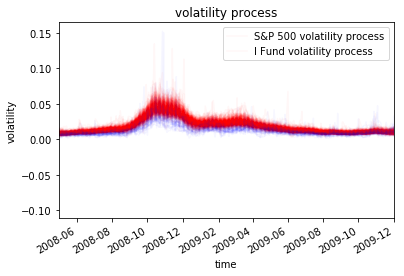

In [7]:
for i in range(len(tspreader.columns)):
    fund_returns = tspreader.iloc[:,i].pct_change()
    with Model() as fund_model:
        nu_f = Exponential('nu', 50, testval=5.)
        sigma_f = Exponential('sigma_f', 1./.02, testval=.1)
        s_f = GaussianRandomWalk('s_f', sigma_f**-2, shape=len(fund_returns))
        volatility_process_f = Deterministic('volatility_process_f', exp(-2*s_f))
        r_f = StudentT('r_f', nu_f, lam=1/volatility_process_f, observed=fund_returns)
    with fund_model:
        trace = sample(200, progressbar=False)
    fig, ax = plt.subplots()
    returns.plot(ax=ax)
    ax.lines[0].remove()
    ax.plot(returns.index,1/np.exp(mkt_trace['s',::5].T), 'r', alpha=.03);
    ax.plot(fund_returns.index,1/np.exp(trace['s_f',::5].T), 'b', alpha=.03);
    ax.set(title='volatility process', xlabel='time', ylabel='volatility');
    ax.legend(['S&P 500 volatility process', str(list(tspreader)[i]) + ' ' + 'volatility process'])
So it s    plt.show()

In general, it looks like the volatilities for a lot of TSP retirement funds are less than the volatilities in the S&P 500, which makes sense given the mission statement of TSP. But some funds are 

! testest

In [10]:
tspreader['G Fund']

date
2008-05-02    12.4300
2008-05-05    12.4300
2008-05-06    12.4300
2008-05-07    12.4300
2008-05-08    12.4300
2008-05-09    12.4300
2008-05-12    12.4400
2008-05-13    12.4400
2008-05-14    12.4400
2008-05-15    12.4400
2008-05-16    12.4400
2008-05-19    12.4500
2008-05-20    12.4500
2008-05-21    12.4500
2008-05-22    12.4500
2008-05-23    12.4500
2008-05-27    12.4600
2008-05-28    12.4600
2008-05-29    12.4600
2008-05-30    12.4600
2008-06-02    12.4700
2008-06-03    12.4700
2008-06-04    12.4700
2008-06-05    12.4700
2008-06-06    12.4700
2008-06-09    12.4700
2008-06-10    12.4800
2008-06-11    12.4800
2008-06-12    12.4800
2008-06-13    12.4800
               ...   
2009-10-19    13.0408
2009-10-20    13.0418
2009-10-21    13.0429
2009-10-22    13.0440
2009-10-23    13.0451
2009-10-26    13.0483
2009-10-27    13.0494
2009-10-28    13.0505
2009-10-29    13.0515
2009-10-30    13.0537
2009-11-02    13.0559
2009-11-03    13.0570
2009-11-04    13.0581
2009-11-05    13.0592
2009-